# Imports

In [1]:
# HIDE 
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')
sys.path.append('../../')

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import time

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as t_optim
import pickle
from IPython import display
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.patches as mpatches
from fairness.helpers import *

from fairness.helpers import *
from fairness.avd_helpers import *

import aif360
from aif360.datasets import CompasDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow.compat.v1 as tf
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import LFR
from aif360.sklearn.preprocessing import LearnedFairRepresentations as LFRsk

from fairlearn_int.adversarial import AdversarialFairnessClassifier as AFC
from fairlearn_int.postprocessing import ThresholdOptimizer as TO

torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="colorblind", color_codes=True, context="talk")
sns.set_theme()

tf.disable_eager_execution()

%matplotlib inline

### Load Data

In [5]:
df = pd.read_csv('../../data/credit/default of credit card clients.csv', sep=';', header=1)

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
X = pd.get_dummies(df.drop(columns=['SEX', 'default payment next month', 'ID']))
y = df.rename({'default payment next month': 'default'}, axis=1).default
Z = (df.SEX==1).astype(int)

In [8]:
(X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(X, y, Z, stratify=y)

### Train Biased Classifier

In [9]:
train_data = TensorDataset(
    torch.Tensor(X_train.to_numpy()), torch.Tensor(y_train.to_numpy()).reshape(-1,1), torch.Tensor(Z_train.to_numpy())
)
test_data = TensorDataset(
    torch.Tensor(X_test.to_numpy()), torch.Tensor(y_test.to_numpy()), torch.Tensor(Z_test.to_numpy())
)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)


clf = Classifier_old(n_features=X_train.shape[1])
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

N_CLF_EPOCHS = 30

# pretrain classifier

biased_model, losses = fit_clf(clf, clf_optimizer, clf_criterion, train_loader, num_epochs=N_CLF_EPOCHS)

preds = biased_model(test_data.tensors[0]).detach()

y_pred = pd.Series(preds.data.numpy().ravel(),
                     index=y_test.index)

acc = metrics.accuracy_score(y_test, y_pred > 0.5) * 100
b_acc = metrics.balanced_accuracy_score(y_test, y_pred > 0.5) * 100
prule = p_rule(y_pred, Z_test.values)

print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'p-rule = {prule:2f}%')

accuracy = 81.60%
balanced accuracy = 66.65%
p-rule = 83.251406%


In [11]:
test_results = pd.DataFrame(Z_test).assign(biased_pred = (y_pred>0.5)*1,
                                          target = y_test).rename({'SEX':'sex'}, axis=1)
test_results.head()

,sex,biased_pred,target
9112,0,0,0
5514,0,0,0
10884,1,0,0
14055,0,0,0
4164,1,0,0


### LFR

In [12]:
lfrsk = LFRsk(prot_attr='sex', reconstruct_weight=0.01,
                 target_weight=1., fairness_weight=14, random_state=11).fit(X_train.assign(sex=Z_train).set_index('sex'), y_train)

X_train_transf = lfrsk.transform(X_train.assign(sex=Z_train).set_index('sex')).set_index(X_train.index)
X_test_transf = lfrsk.transform(X_test.assign(sex=Z_test).set_index('sex')).set_index(X_test.index)

train_data = TensorDataset(torch.Tensor(X_train_transf.to_numpy()), 
                           torch.Tensor(y_train.to_numpy().reshape(-1,1)),
                           torch.Tensor(Z_train.to_numpy()))

test_data = TensorDataset(torch.Tensor(X_test_transf.to_numpy()), 
                          torch.Tensor(y_test.to_numpy()), 
                          torch.Tensor(Z_test.to_numpy()))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

start = time.time()

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=False)

clf = Classifier_old(n_features=X_train.shape[1])
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters())

n_epochs = 30

# pretrain classifier

clf, losses = fit_clf(clf, clf_optimizer, clf_criterion, train_loader, num_epochs=n_epochs)

with torch.no_grad():
    preds = clf(test_data.tensors[0])

y_pred = pd.Series(preds.data.numpy().ravel(),
                     index=y_test.index)

acc = metrics.accuracy_score(y_test, y_pred > 0.5) * 100
b_acc = metrics.balanced_accuracy_score(y_test, y_pred > 0.5) * 100
prule = p_rule(y_pred, Z_test.values)

print(f'accuracy = {acc:.2f}%')
print(f'balanced accuracy = {b_acc:.2f}%')
print(f'p-rule = {prule:2f}%')

accuracy = 80.16%
balanced accuracy = 63.33%
p-rule = 94.481522%


In [13]:
test_results = test_results.assign(
    lfr_pred = (y_pred>0.5).astype(int)
)

In [14]:
test_results = test_results.assign(lfr_change = test_results.lfr_pred - test_results.biased_pred)

### Adversarial Debiasing

In [16]:
afc = AFC(backend='torch',
   predictor_model=[32, nn.ReLU(), 32, nn.ReLU(), 32, nn.ReLU()],
   adversary_model=[200, nn.ReLU()],
   epochs=30,
   alpha=14).fit(X_train, y_train, sensitive_features=Z_train)

preds = afc.predict(X_test)

In [17]:
print(f'accuracy = {metrics.accuracy_score(y_test, (preds>0.5) * 1) * 100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, (preds>0.5) * 1) * 100:.2f}%')
print(f'p-rule = {p_rule((preds>0.5) * 1, Z_test.values):.2f}%')

accuracy = 80.79%
balanced accuracy = 64.55%
p-rule = 90.41%


In [18]:
preds.index=test_results.index

In [19]:
test_results = test_results.assign(adv_pred = (preds>0.5)*1, adv_change = (preds>0.5)*1 - test_results.biased_pred)
test_results.head()

,sex,biased_pred,target,lfr_pred,lfr_change,adv_pred,adv_change
9112,0,0,0,0,0,0,0
5514,0,0,0,0,0,0,0
10884,1,0,0,0,0,0,0
14055,0,0,0,0,0,0,0
4164,1,0,0,0,0,0,0


### Adversarial Learning (Equalized Odds)

In [21]:
afc = AFC(backend='torch',
   predictor_model=[32, nn.ReLU(), 32, nn.ReLU(), 32, nn.ReLU()],
   adversary_model=[200, nn.ReLU()],
   constraints='equalized_odds',
   epochs=30,
   alpha=25).fit(X_train, y_train, sensitive_features=Z_train)

preds = afc.predict(X_test)

In [22]:
preds.index = X_test.index
test_results = test_results.assign(adveq_pred = preds, adveq_change = preds - test_results.biased_pred)

In [24]:
print('Adversarial (optimizing equalized odds):')
print(f'accuracy = {metrics.accuracy_score(y_test, preds) * 100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, preds) * 100:.2f}%')
dm = disparate_mistreatment(test_results[['sex', 'target', 'adveq_pred']].rename({'adveq_pred':'fair_label'}, axis=1), 'sex')
print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')

print()
print('Biased:')
print(f'accuracy = {metrics.accuracy_score(y_test, test_results.biased_pred) * 100:.2f}%')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, test_results.biased_pred) * 100:.2f}%')
dm = disparate_mistreatment(test_results[['sex', 'target', 'biased_pred']].rename({'biased_pred':'fair_label'}, axis=1), 'sex')
print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')

Adversarial (optimizing equalized odds):
accuracy = 81.57%
balanced accuracy = 64.44%
disparate mistreatement: D(FPR) = 0.79, D(TPR) = 0.87

Biased:
accuracy = 81.60%
balanced accuracy = 66.65%
disparate mistreatement: D(FPR) = 1.47, D(TPR) = 1.63


### Equal Odds

In [29]:
bld_train = BinaryLabelDataset(df=X_train.assign(y = y_train, sex = Z_train), label_names=['y'], protected_attribute_names=['sex'])

In [30]:
m = TO(estimator=biased_model, predict_method='predict',
       prefit=True, constraints='equalized_odds',
      objective='accuracy_score').fit(X=X_train.assign(sex=Z_train).set_index('sex'), 
                                                             y=y_train,
                                                             Z=Z_train, 
                                                             sensitive_features=Z_train,
                                                                         bld=None)

In [31]:
preds = m.predict(X=X_test, y=y_test, Z=Z_test, sensitive_features=Z_test,
                  bld=None)
                 

In [32]:
test_results = test_results.assign(
    eq_pred = preds,
    eq_change = preds - test_results.biased_pred
)

In [33]:
acc = metrics.accuracy_score(y_test, preds)
b_acc = metrics.balanced_accuracy_score(y_test, preds)
dm = disparate_mistreatment(test_results[['sex', 'target', 'eq_pred']].rename({'eq_pred':'fair_label'}, axis=1), 'sex')

print(f'accuracy = {acc:.2f}')
print(f'balanced accuracy = {b_acc:.2f}')
print(f'disparate mistreatement: D(FPR) = {dm[0]:.2f}, D(TPR) = {dm[1]:.2f}')

accuracy = 0.82
balanced accuracy = 0.66
disparate mistreatement: D(FPR) = 0.26, D(TPR) = 1.84


### Reject Option Classification

In [34]:
scores = biased_model(test_data.tensors[0]).detach().numpy().flatten()
labels = (scores>0.5)*1

preds = RejectOptionClassifier(0.545).predict(scores, Z_test.values)

In [35]:
print(f'accurcy = {metrics.accuracy_score(y_test, labels)*100:.2f}')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, labels)*100:.2f}')
print(f'p-rule = {p_rule(scores, Z_test.values):.2f}')

print('-------------')
print('debiased:')

print(f'accuracy = {metrics.accuracy_score(y_test, preds)*100:.2f}')
print(f'balanced accuracy = {metrics.balanced_accuracy_score(y_test, preds)*100:.2f}')
print(f'p-rule = {p_rule(preds, Z_test.values):.2f}')

accurcy = 79.90
balanced accuracy = 57.69
p-rule = 99.16
-------------
debiased:
accuracy = 79.88
balanced accuracy = 57.55
p-rule = 93.12


In [36]:
test_results = test_results.assign(
    roc_pred=preds,
    roc_change = preds - test_results.biased_pred
)

# Comparisons

In [37]:
test_results.head()
t = test_results

In [38]:
metrics_ = get_metrics([t[['sex', 'target', 'adv_pred', 'biased_pred']].rename({'biased_pred':'biased_label', 'adv_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'roc_pred']].rename({'biased_pred':'biased_label', 'roc_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'lfr_pred']].rename({'biased_pred':'biased_label', 'lfr_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'adveq_pred']].rename({'biased_pred':'biased_label', 'adveq_pred':'fair_label'}, axis=1),
                        t[['sex', 'target', 'eq_pred']].rename({'biased_pred':'biased_label', 'eq_pred':'fair_label'}, axis=1),
                       ],
                       ['adversarial (dem parity)', 'ROC', 'LFR', 'adversarial (eq odds)', 'eq odds'],
                       sensitive_feature='sex'
                      )
metrics_.drop(columns=['class 0 accuracy', 'class 1 accuracy'])


,approach,accuracy,balanced accuracy,p% rules,fpr_diffs,tpr_diffs
0,adversarial (dem parity),0.807867,0.645543,90.411716,0.499417,0.158952
1,ROC,0.798800,0.575526,93.120310,0.345886,2.788406
2,LFR,0.801600,0.633319,94.481522,0.177330,1.325339
3,adversarial (eq odds),0.815733,0.644443,85.753329,0.788455,0.874456
4,eq odds,0.816133,0.657323,93.857751,0.263694,1.842859
5,biased,0.816000,0.666517,83.251406,1.471019,1.628178


Text(0.5, 1.0, 'Methods Optimizing Equalized Odds')

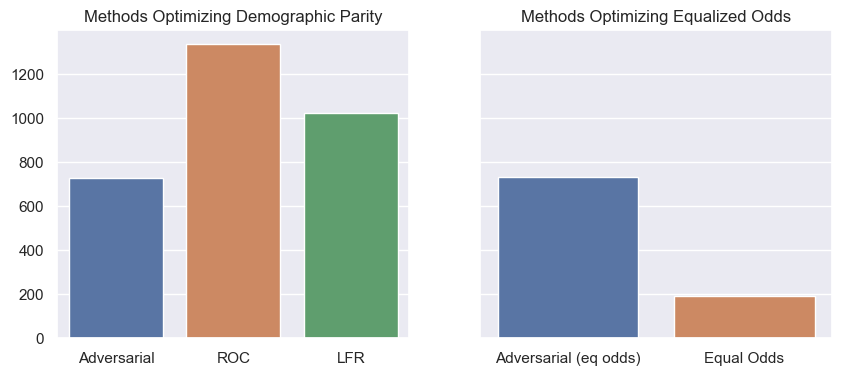

In [39]:
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)

sns.barplot(
    x=['Adversarial', 'ROC', 'LFR'],
    y=[len(t[t.adv_change!=0]), len(t[t.roc_change!=0]),
      len(t[t.lfr_change!=0])],
    ax=axs[0]
           )
axs[0].set_title('Methods Optimizing Demographic Parity')

sns.barplot(
    x = ['Adversarial (eq odds)', 'Equal Odds'],
    y = [len(t[t.adveq_change!=0]), len(t[t.eq_change!=0])],
    ax=axs[1]
)
axs[1].set_title('Methods Optimizing Equalized Odds')

In [40]:
tt = t[(t.adv_change!=0) | (t.roc_change!=0) | (t.lfr_change!=0)]
inters_dp = len(tt[(tt.adv_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_change)])
union_dp = len(tt)
iou_dp = inters_dp/union_dp * 100

print('Demographic parity methods:')
print(f'IOU(changed instances) = {iou_dp:.2f}%')

tt = t[(t.adveq_change!=0) | (t.eq_change!=0)]
inters_eo = len(tt[(tt.adveq_change==tt.eq_change)])
union_eo = len(tt)
iou_eo = inters_eo/union_eo * 100

print('Equalized Odds methods:')
print(f'IOU(changed instances) = {iou_eo:.2f}%')

tt = t[(t.adv_change!=0) | (t.roc_change!=0) | (t.lfr_change!=0) | (t.adveq_change!=0) | (t.eq_change!=0)]
inters = len(tt[
    (tt.adv_change==tt.roc_change) & (tt.lfr_change==tt.roc_change) & (tt.lfr_change==tt.adv_change) &
    (tt.adveq_change==tt.eq_change) &
    (tt.adv_change==tt.adveq_change) & (tt.lfr_change==tt.adveq_change) & (tt.roc_change==tt.adveq_change) &
    (tt.adv_change==tt.eq_change) & (tt.lfr_change==tt.eq_change) & (tt.roc_change==tt.eq_change) 
])
union = len(tt)
iou = inters/union

print('All methods:')
print(f'IOU(changed instances) = {iou:.2f}%')

Demographic parity methods:
IOU(changed instances) = 9.46%
Equalized Odds methods:
IOU(changed instances) = 15.08%
All methods:
IOU(changed instances) = 0.02%


In [41]:
print('LFR:')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.lfr_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.lfr_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('Adversarial (DP):')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.adv_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.adv_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('ROC:')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.roc_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.roc_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()

print('Biased:')
print(f'disadv group in positive class: {len(t[(t.sex==0) & (t.biased_pred==1)]) / len(t[t.sex==0]) * 100:.2f}%')
print(f'priv group in positive class: {len(t[(t.sex==1) & (t.biased_pred==1)]) / len(t[t.sex==1]) * 100:.2f}%')
print()


LFR:
disadv group in positive class: 12.11%
priv group in positive class: 12.82%

Adversarial (DP):
disadv group in positive class: 12.26%
priv group in positive class: 13.56%

ROC:
disadv group in positive class: 5.91%
priv group in positive class: 5.50%

Biased:
disadv group in positive class: 12.89%
priv group in positive class: 15.48%



In [42]:
t_fts = df.loc[t.index].join(t)

adv_changed = t_fts[t_fts.adv_change!=0]
eq_changed = t_fts[t_fts.eq_change!=0]
roc_changed = t_fts[t_fts.roc_change!=0]

adv_changed.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,lfr_pred,lfr_change,adv_pred,adv_change,adveq_pred,adveq_change,eq_pred,eq_change,roc_pred,roc_change
13106,13107,360000,2,1,1,49,1,-2,-2,-2,...,0,0,1,1,0,0,0,0,0.0,0.0
7776,7777,360000,2,2,1,46,1,-2,-2,-2,...,0,0,1,1,0,0,0,0,0.0,0.0
13261,13262,60000,2,2,1,60,8,7,6,5,...,1,0,0,-1,1,0,1,0,1.0,0.0
26840,26841,70000,1,1,2,38,2,-1,-1,-1,...,0,0,1,1,1,1,0,0,0.0,0.0
15231,15232,20000,2,3,1,42,2,2,2,0,...,1,0,0,-1,0,-1,1,0,0.0,-1.0


# T-SNE

In [43]:
a_df = t[t.adv_change!=0]
l_df = t[t.lfr_change!=0]
e_df = t[t.eq_change!=0]
r_df = t[t.roc_change!=0]
ae_df = t[t.adv_change!=0]

In [44]:
from sklearn.manifold import TSNE

tsne_df = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=25).fit_transform(X_test)#.assign(z = Z_test))

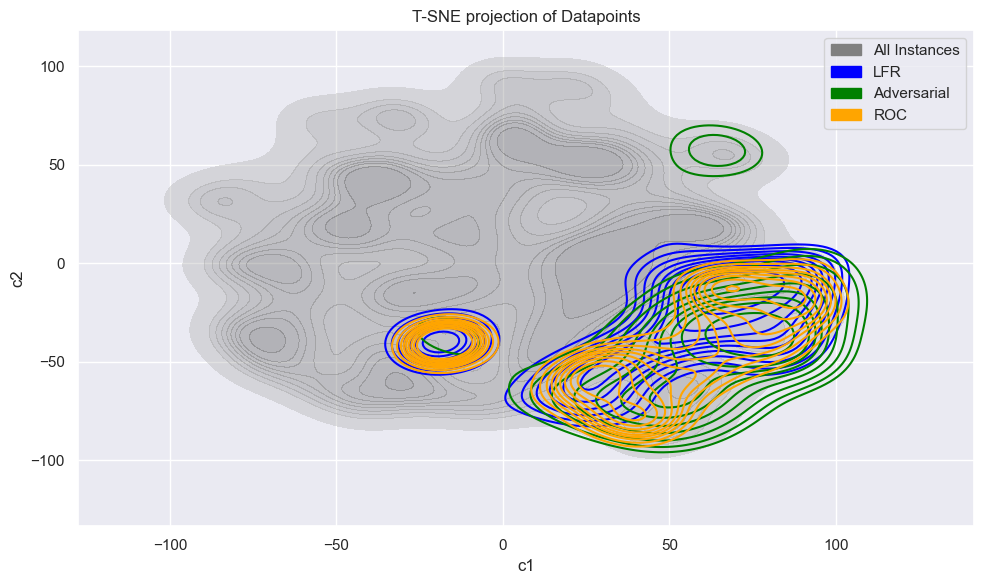

In [46]:
tsne_plot(
    pd.DataFrame(tsne_df, index=X_test.index, columns=['c1', 'c2']),
    {'LFR': l_df, 'Adversarial':a_df, 'ROC':r_df},
    {'LFR': 'Blue', 'Adversarial':'Green', 'ROC':'Orange'}
)

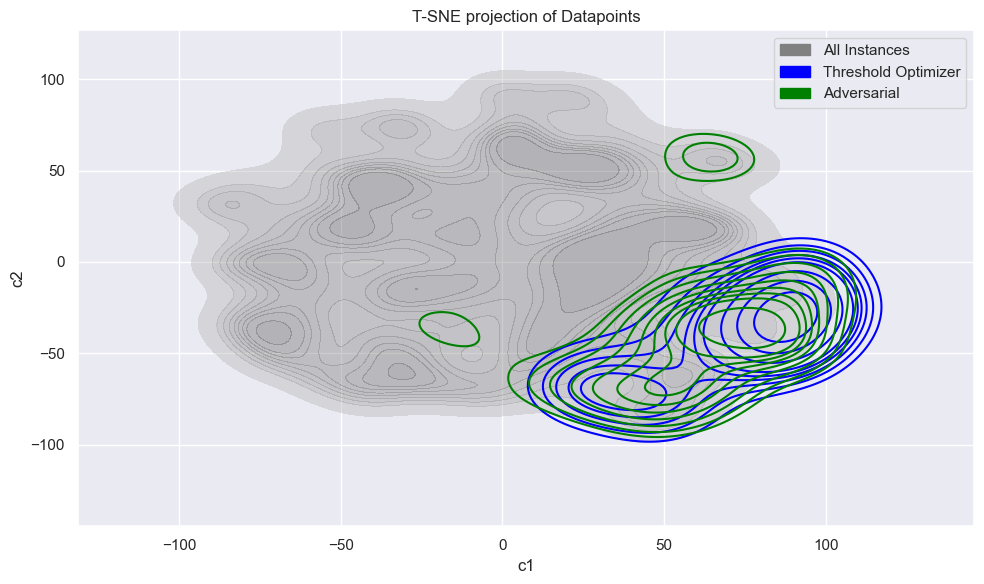

In [47]:
tsne_plot(
    pd.DataFrame(tsne_df, index=X_test.index, columns=['c1', 'c2']),
    {'Threshold Optimizer': e_df, 'Adversarial':ae_df},
    {'Threshold Optimizer': 'Blue', 'Adversarial':'Green'}
)